---
Hierarchical clustering of flow cytometry data
---

Annette Hynes, UW

----
Loading packages

In [1]:
library(tidyverse)
library(gridExtra)
library(viridis)
library(protoclust)
library(dynamicTreeCut)
library(moduleColor)
library(arrow)
library(grid)
library(gridExtra)
library(repr)
library(purrr)
library(magick)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Loading required package: viridisLite

Loading required package: impute


Attaching package: 'arrow'


The following object is masked from 'package:utils':

    timestamp


Linking to ImageMagick 6.9.12.3
Enabled features: cairo, fontconfig, freetype, heic, lcms, pango, raw, rsvg, webp
Disabled features: fftw, ghostscript, x11



----
Useful functions from *popcycle*

In [2]:
untransformData <- function (df, columns = NULL)
{
    if (nrow(df) == 0) {
        return(df)
    }
    if (is.null(columns)) {
        columns <- (names(df) %in% c("D1", "D2", "fsc_small",
            "fsc_perp", "fsc_big", "pe", "chl_small", "chl_big"))
    }
    df[, columns] <- (log10(df[, columns])/3.5) * 2^16
    return(df)
}

plot_cytogram <- function (evtopp, para.x = "fsc_small", para.y = "chl_small",
    bins = 100, transform = T, xlim = NULL, ylim = NULL)
{
    p <- evtopp %>% ggplot2::ggplot() + ggplot2::stat_bin_2d(ggplot2::aes_string(para.x,
        para.y), bins = bins, color = NA) + viridis::scale_fill_viridis() +
        ggplot2::theme_bw()
    if (transform) {
        p <- p + ggplot2::scale_y_continuous(trans = "log10",
            limits = xlim) + ggplot2::scale_x_continuous(trans = "log10",
            limits = ylim)
    }
    else {
        p <- p + ggplot2::scale_y_continuous(limits = xlim) +
            ggplot2::scale_x_continuous(limits = ylim)
    }
    return(p)
}


----
Loading data

In [3]:
##########################
### PATHS AND DATABASE ###
##########################

cruise <- "HOT297"
path <- paste0('/Users/annettehynes/SeaFlow/Clone/ohw-proj-flow-cytometry-data/', cruise, '/')
save_path <- path
opp_dir <- paste0(path, cruise, "_opp")

################################
### OPEN DATA IN A DATAFRAME ###
################################

full_paths <- list.files(opp_dir, pattern=paste0("*.opp.parquet"), full.names=TRUE)
filenames <- basename(full_paths)

# Grab the time stamps from file names
parts <- strsplit(filenames, ".", fixed=TRUE)   
timestamps <- sapply(parts, function(x) x[1])
date_vec <- substr(timestamps, 1, 19)   # cut off after seconds
nrows <- length(date_vec)

indl <- logical(length = nrows)
big_data <- NULL
n <- 2000 # standardize number of particles per cytogram. 10000 was too much to visualize the tree cut comparisons
for (k in seq_along(date_vec)) {    # Grab OPP by hour
    print(k)  # Track progress in loop
    opp <- as.data.frame(arrow::read_parquet(full_paths[k]))
    if (!nrow(opp) == 0){
        indl[k] <- TRUE
        opp <- opp[which(opp$fsc_small > 2 & opp$chl_small > 2), ] # trim the large number of particles with very low values
        if(nrow(opp) < n){   # If the hour is sparse, take all the particles
            opp_samp <- opp
        }else{
            opp_samp <- dplyr::slice_sample(opp, n = n)   # take only n particles
        }
        opp_samp$DateTime <- date_vec[k]
        big_data <- rbind(big_data, opp_samp[, c("DateTime", "fsc_small", "chl_small", "pe")]) # keep just the columns of interest
    }
}

write.csv(big_data, file = paste0(save_path, cruise, "_2000pts_hourly_3param.csv"), row.names = FALSE)


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74


----
Plot cytograms and histograms from one hour

Warning message:
"Removed 117 rows containing non-finite values (stat_bin)."
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 50 rows containing missing values (geom_bar)."
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 62 rows containing missing values (geom_bar)."
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 65 rows containing missing values (geom_bar)."


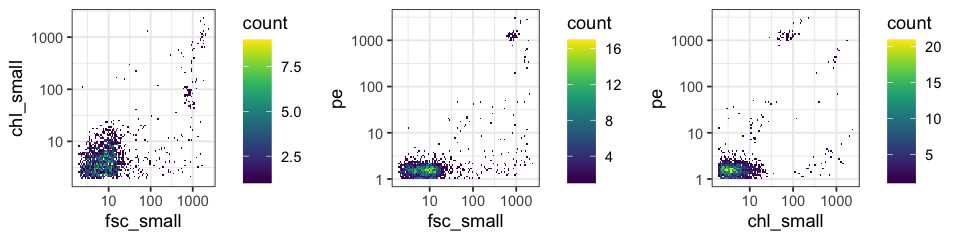

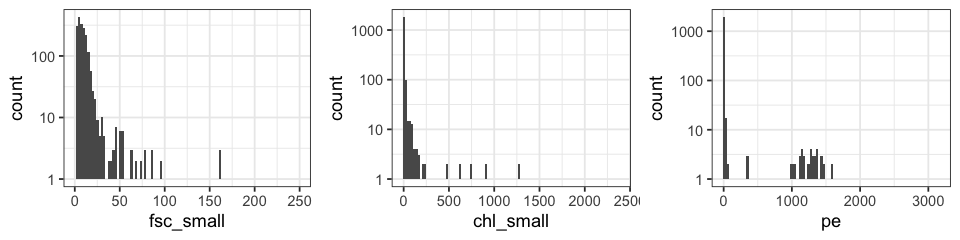

In [4]:
ind <- 1
this_time <- date_vec[ind]
this_data <- dplyr::filter(big_data, DateTime == this_time)

# cytograms
p1 <- plot_cytogram(this_data, para.x = "fsc_small", para.y = "chl_small") # these are all ggplot objects
p2 <- plot_cytogram(this_data, para.x = "fsc_small", para.y = "pe")
p3 <- plot_cytogram(this_data, para.x = "chl_small", para.y = "pe")

options(repr.plot.width = 8, repr.plot.height = 2)   # Controls figure size within notebook
gridExtra::grid.arrange(p1, p2, p3, ncol = 3)  # put subplots together

# histograms
h1 <- ggplot2::ggplot(this_data) +
    geom_histogram(aes(x = fsc_small), bins = 100) +
    theme_bw() +
    scale_y_log10() + xlim(c(0, 250))

h2 <- ggplot2::ggplot(this_data) +
    geom_histogram(aes(x = chl_small), bins = 100) +
    theme_bw() +
    scale_y_log10()

h3 <- ggplot2::ggplot(this_data) +
    geom_histogram(aes(x = pe), bins = 100) +
    theme_bw() +
    scale_y_log10()

options(repr.plot.width = 8, repr.plot.height = 2)
gridExtra::grid.arrange(h1, h2, h3, ncol = 3)

----
K means clustering

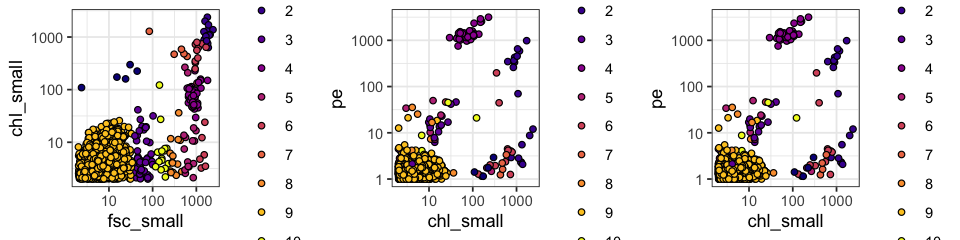

In [5]:

data_in <- this_data[c('fsc_small', 'chl_small', 'pe')]
k = 10  # number clusters
k_flow <- kmeans(x = data_in, centers = k, iter.max = 100)
this_data$cluster <- as.factor(k_flow$cluster)

g1 <- ggplot(this_data) +
    geom_point(aes(x = fsc_small, y = chl_small, fill = cluster), pch = 21) +
    theme_bw() +
    scale_color_discrete() +
    scale_y_continuous(trans='log10') +
    scale_x_continuous(trans='log10') +
    scale_fill_manual(values = viridis::plasma(k))

g2 <- ggplot(this_data) +
    geom_point(aes(x = fsc_small, y = pe, fill = cluster), pch = 21) +
    theme_bw() +
    scale_color_discrete() +
    scale_y_continuous(trans='log10') +
    scale_x_continuous(trans='log10') +
    scale_fill_manual(values = viridis::plasma(k))

g3 <- ggplot(this_data) +
    geom_point(aes(x = chl_small, y = pe, fill = cluster), pch = 21) +
    theme_bw() +
    scale_color_discrete() +
    scale_y_continuous(trans='log10') +
    scale_x_continuous(trans='log10') +
    scale_fill_manual(values = viridis::plasma(k))

gridExtra::grid.arrange(g1, g3, g3, ncol = 3)


The k-means clustering did well in distinguishing beads from *Crocosphaera*, but did not resolve *Synechococcus*.  I decided to try hierarchical clustering and implement *dynamicTreeCut* to have some flexibility in resolving clusters.


----
Hierarchical clustering

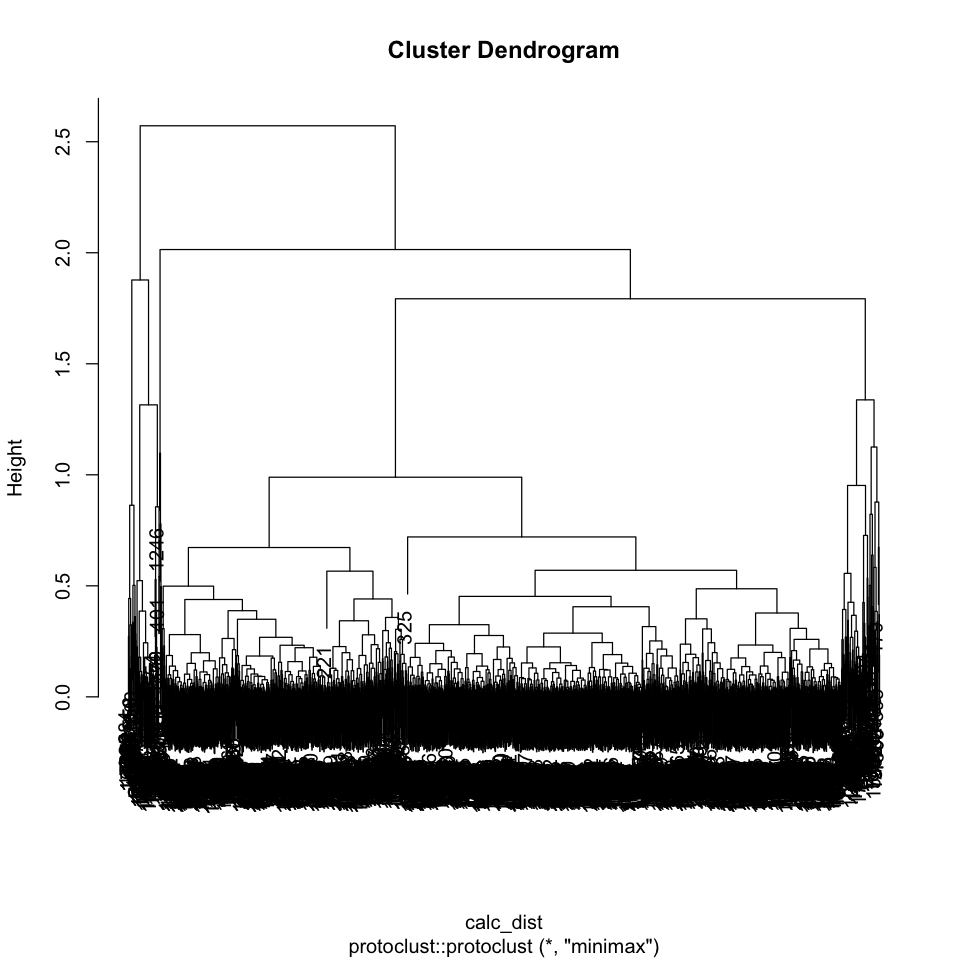

In [10]:
# The data values currently goes up to > 3000.  In order to resolve small, low-fluorescence particles, use the log of the values.
calc_dist <- dist(log10(data_in))

options(repr.plot.width = 8, repr.plot.height = 8)
proto1 <- protoclust::protoclust(calc_dist)
protoclust::plotwithprototypes(proto1)
dmat <- as.matrix(calc_dist)

----
Trim the tree


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: 'Hmisc'


The following objects are masked from 'package:dplyr':

    src, summarize


The following objects are masked from 'package:base':

    format.pval, units


Loading required package: spam

Spam version 2.8-0 (2022-01-05) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve



Try help(fields) to get started.


Attaching package: 'fields'


The following object is masked from 'package:Hmisc':

    describe


Warning message:
"'memory.limit()' is Windows-specific"


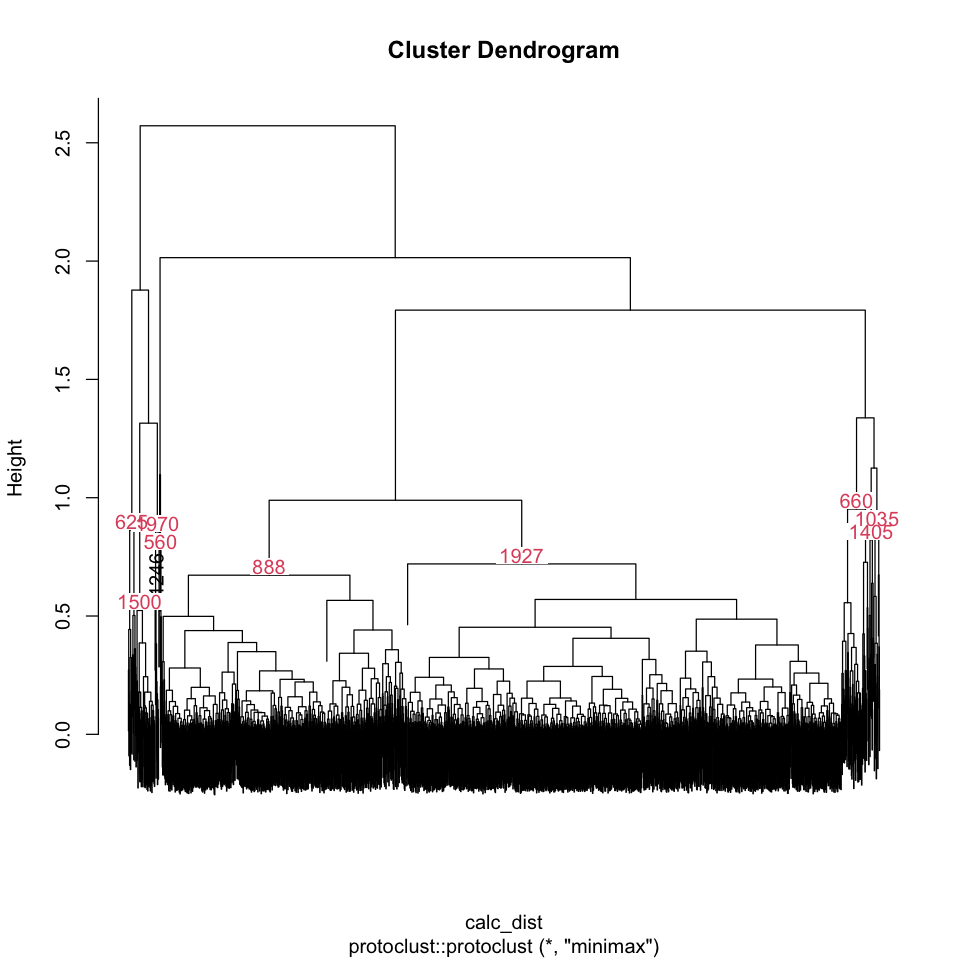

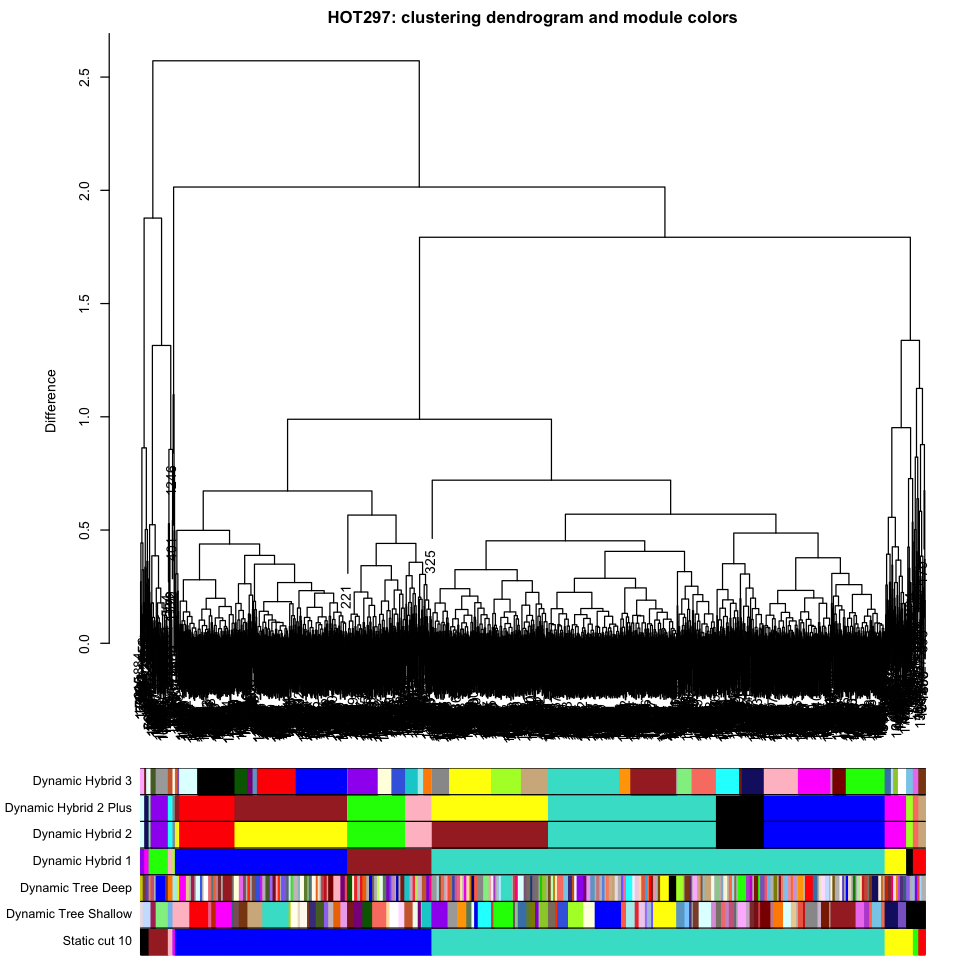

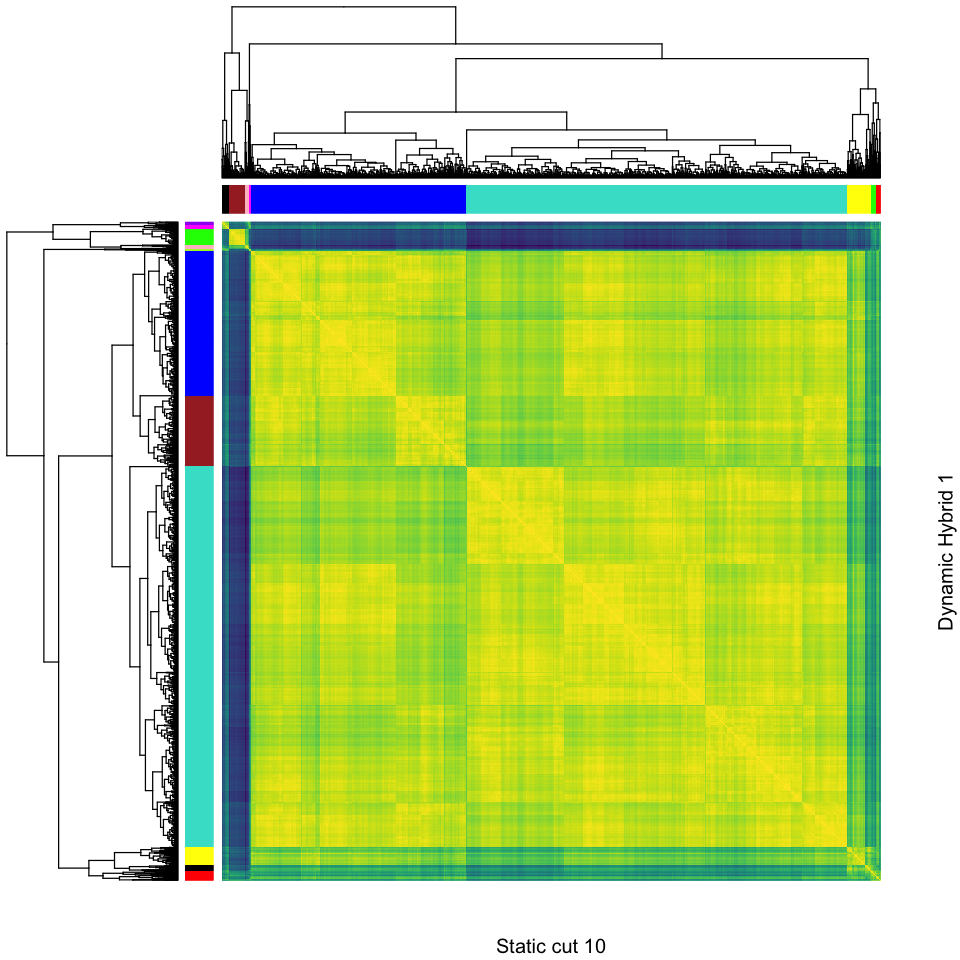

In [11]:
# Import functions from an example by the dynamicTreeCut authors
source("~/Documents/Computer/R/Example-Toy/NetworkFunctions-TreeCut-Simulation.R");

k <- 10    # number of branches to cut the tree into
cut <- protoclust::protocut(proto1, k=k)
protoclust::plotwithprototypes(proto1, imerge=cut$imerge, col=2)    # Plot dendogram

# Dynamic cut
hc2 <- proto1
class(hc2) <- "hclust"  # dynamic tree cut fns will throw an error for more than one class
data <- seq(1, nrow(data_in))

# Try a variety of tree cut parameters.
# Tree method results in error:  Error in mydemdroHei.order[, 1] : incorrect number of dimensions
clust_TT <- dynamicTreeCut::cutreeDynamic(dendro = hc2, minClusterSize = 5, method = "tree", deepSplit = TRUE)
clust_TF <- dynamicTreeCut::cutreeDynamic(dendro = hc2, minClusterSize = 5, method = "tree", deepSplit = FALSE)
clust_H1 <- dynamicTreeCut::cutreeDynamic(dendro = hc2, minClusterSize = 5, method = "hybrid", deepSplit = 1,
    pamStage = TRUE,  distM = dmat, maxPamDist = 0, verbose = 0)
clust_H2 <- dynamicTreeCut::cutreeDynamic(dendro = hc2, minClusterSize = 5, method = "hybrid", deepSplit = 2,
    pamStage = TRUE,  distM = dmat, maxPamDist = 0, verbose = 0)
clust_H2_plus <- dynamicTreeCut::cutreeDynamic(dendro = hc2, minClusterSize = 5, method = "hybrid", deepSplit = 2,
        pamStage = TRUE,  distM = dmat, verbose = 0, pamRespectsDendro = FALSE) # default maxPamDist = cutHeight
clust_H3 <- dynamicTreeCut::cutreeDynamic(dendro = hc2, minClusterSize = 5, method = "hybrid", deepSplit = 3,
        pamStage = TRUE,  distM = dmat, maxPamDist = 0, verbose = 0)

DetectedColors <- cbind(labels2colors(cut$cl), labels2colors(clust_TF), labels2colors(clust_TT),
    labels2colors(clust_H1), labels2colors(clust_H2), labels2colors(clust_H2_plus), labels2colors(clust_H3))

Methods <- c("Static cut 10", "Dynamic Tree Shallow", "Dynamic Tree Deep",
    "Dynamic Hybrid 1", "Dynamic Hybrid 2", "Dynamic Hybrid 2 Plus", "Dynamic Hybrid 3");

# Color-coded dendograms
layout(matrix(c(1,2), nrow = 2, ncol = 1), widths = 1, heights = c(0.8, 0.2))
par(cex = 0.7)
par(mar=c(0, 6.5, 2, 0.2))
plot(hc2, labels = data,
     main = paste0(cruise, ": clustering dendrogram and module colors"), ylab = "Difference")
par(mar = c(0.2, 6.5, 0, 0.2))
hclustplotn(hc2, DetectedColors, RowLabels = Methods, main="")  # Fn from NetworkFunctions-TreeCut-Simulation.R

 # Heatmap with two color-coded dendograms: topological overlap matrix (TOM)
heatmap(dmat, Rowv = as.dendrogram(hc2), Colv = as.dendrogram(hc2), scale = "none", revC = T,
    ColSideColors = as.character(DetectedColors[, 1]), RowSideColors=as.character(DetectedColors[, 4]),
    labRow=F, labCol=F, col = rev(viridis::viridis(100)), xlab = Methods[1], ylab = Methods[4])


----
Apply 10-branch cut to hourly data

The dynamic tree and hybrid methods all cut deeper than necessary.  A static branch cut at 10 branches was sufficient to cluster beads, *Crocosphaera*, *Synechococcus*, and picoeukaryotes.  *Prochlorococcus* was clustered with low-fsc and low-chl noise with occasional sub-clusters.

In [12]:

big_data <- read.csv(file = paste0(save_path, cruise, "_2000pts_hourly_3param.csv"))
k <- 10 # number of clusters/branches
fig_dir <- paste0(save_path, '10cut_figs')

for (i in seq(1, length(date_vec))){

    this_time <- date_vec[i]
    print(this_time)   # track progress as you step through loop
    this_data <- dplyr::filter(big_data, DateTime == this_time)
    data_in <- this_data[c('fsc_small', 'chl_small', 'pe')]
    calc_dist <- dist(log10(data_in))
    proto1 <- protoclust::protoclust(calc_dist)
    cut <- protoclust::protocut(proto1, k=k)

    this_data$cut10 <- cut$cl
    
  # plot results for each hour 
    g1 <- ggplot(this_data) +
        geom_point(aes(x = fsc_small, y = chl_small, fill = factor(cut10)), pch = 21, size = 3) +
        theme_bw(base_size = 18) +
        scale_color_discrete() +
        scale_y_continuous(trans='log10') +
        scale_x_continuous(trans='log10') +
        scale_fill_manual(values = viridis::plasma(k), name = "clust") +
        labs(title = 'Cut 10')

    g2 <- ggplot(this_data) +
        geom_point(aes(x = fsc_small, y = pe, fill = factor(cut10)), pch = 21, size = 3) +
        theme_bw(base_size = 18) +
        scale_color_discrete() +
        scale_y_continuous(trans='log10') +
        scale_x_continuous(trans='log10') +
        scale_fill_manual(values = viridis::plasma(k), name = "clust") +
        labs(title = 'Cut 10')

    g3 <- ggplot(this_data) +
        geom_point(aes(x = chl_small, y = pe, fill = factor(cut10)), pch = 21, size = 3) +
        theme_bw(base_size = 18) +
        scale_color_discrete() +
        scale_y_continuous(trans='log10') +
        scale_x_continuous(trans='log10') +
        scale_fill_manual(values = viridis::plasma(k), name = "clust") +
        labs(title = 'Cut 10')
    t <- textGrob(this_time, gp=gpar(fontsize=20))

    fig_name = paste0(fig_dir, '/', this_time, '.jpg')
    jpeg(fig_name, width = 600*3, height = 600*1)
        gridExtra::grid.arrange(g1, g2, g3, ncol = 3, top = t)
    dev.off()
}

# Stitch images into a .mp4
fig_list <- dir(fig_dir, full.names = TRUE)
out_file <- paste0(save_path, cruise, '_hc_movie.mp4')
av::av_encode_video(input = fig_list, output = out_file, framerate = 10, vfilter = "null", codec = NULL, audio = NULL, verbose = TRUE)

# Stitch images into a .gif
hc_gif <- fig_list %>%
    purr::map(image_read) %>%
    magick::image_join() %>%
    magick::image_animate(fps=4) %>%
    magick::image_write(paste0(save_path, "hc.gif"))


[1] "2017-11-07T22-00-00"
[1] "2017-11-07T23-00-00"
[1] "2017-11-08T00-00-00"
[1] "2017-11-08T01-00-00"
[1] "2017-11-08T02-00-00"
[1] "2017-11-08T03-00-00"
[1] "2017-11-08T04-00-00"
[1] "2017-11-08T05-00-00"
[1] "2017-11-08T06-00-00"
[1] "2017-11-08T07-00-00"
[1] "2017-11-08T08-00-00"
[1] "2017-11-08T09-00-00"
[1] "2017-11-08T10-00-00"
[1] "2017-11-08T11-00-00"
[1] "2017-11-08T12-00-00"
[1] "2017-11-08T13-00-00"
[1] "2017-11-08T14-00-00"
[1] "2017-11-08T15-00-00"
[1] "2017-11-08T16-00-00"
[1] "2017-11-08T17-00-00"
[1] "2017-11-08T18-00-00"
[1] "2017-11-08T19-00-00"
[1] "2017-11-08T20-00-00"
[1] "2017-11-08T21-00-00"
[1] "2017-11-08T22-00-00"
[1] "2017-11-08T23-00-00"
[1] "2017-11-09T00-00-00"
[1] "2017-11-09T01-00-00"
[1] "2017-11-09T02-00-00"
[1] "2017-11-09T03-00-00"
[1] "2017-11-09T04-00-00"
[1] "2017-11-09T05-00-00"
[1] "2017-11-09T06-00-00"
[1] "2017-11-09T07-00-00"
[1] "2017-11-09T08-00-00"
[1] "2017-11-09T09-00-00"
[1] "2017-11-09T10-00-00"
[1] "2017-11-09T11-00-00"
[1] "2017-11

[1] "/Users/annettehynes/SeaFlow/Clone/ohw-proj-flow-cytometry-data/HOT297/HOT297_hc_movie.mp4"

----
Next steps

1.  Subsample the densest regions, especially the low-fsc, low-chl, low-pe quadrant where *Prochlorococcus* occurs.  
2.  Try different distance calculations.  
